## Pre-requisites
---

Connect to Google drive and change working directory

In [1]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)
%cd /content/drive/MyDrive/CS50AI_Project/

Mounted at /content/drive
/content/drive/MyDrive/CS50AI_Project


Install required packages

In [2]:
pip install -r requirements.txt &> /dev/null

Load packages

In [3]:
def load_pkg():
  name_abbr = {"helpers": None,
               "clean_text": None,
               "pandas": "pd",
               "numpy": "np",
               "iso639": None,
               "math": None,
               "random": None,
               "time": None,
               "re": None,
               "unicodedata": None,
               "pickle": None,
               "joblib": None,
               "sentencepiece": "spm",
               "matplotlib.pyplot": "plt",
               "language_detector": None
              }
  pkg_subpkg = {"collections": "Counter",
                "sklearn.feature_extraction.text": "CountVectorizer",
                "sklearn.naive_bayes": "MultinomialNB",
                "sklearn.metrics": "accuracy_score",
                "sklearn.model_selection": "KFold"
                }

  for name, abbr in name_abbr.items():
    if abbr:
      exec(f"import {name} as {abbr}", globals())
    else:
      exec(f"import {name}", globals())

  for pkg, subpkg in pkg_subpkg.items():
    exec(f"from {pkg} import {subpkg}", globals())
load_pkg()

## Dataset

### Load dataset

In [4]:
langdetect_dataset = pd.read_csv("Data/langdetect.csv")

In [5]:
langdetect_dataset['language'].value_counts()

English       10651
French         9747
Spanish        9462
Russian        9160
Portuguese     9138
Arabic         8910
Dutch          8867
Turkish        8820
Japanese       8242
Chinese        8236
Hindi          8174
Thai           8101
Italian        7614
German         7461
Urdu           7389
Greek          7154
Bulgarian      6627
Vietnamese     6607
Polish         6539
Korean         4999
Persian        4998
Danish         4996
Swedish        4994
Romanian       4987
Indonesian     4959
Swahili        4944
Latin          4912
Estonian       4674
Tamil          1842
Malayalam      1471
Pushto         1000
Kannada         543
Name: language, dtype: int64

In [6]:
# drop language with count less than 1000
last1 = langdetect_dataset["language"].value_counts().index[-1]
langdetect_dataset = langdetect_dataset.loc[langdetect_dataset["language"]!=last1,]

In [7]:
langdetect_dataset["split"].value_counts(normalize=True)

train    0.798488
test     0.201512
Name: split, dtype: float64

### Text normalization

1. lowercase text
2. remove multiple whitespaces
3. remove numbers

In [8]:
ordered_colnames = langdetect_dataset.columns.tolist()
langdetect_dataset = langdetect_dataset.copy()
langdetect_dataset["raw"] = langdetect_dataset["text"]
langdetect_dataset = langdetect_dataset[['raw'] + ordered_colnames]

In [9]:
langdetect_dataset = clean_text.lowercase(langdetect_dataset, "text")
langdetect_dataset = clean_text.rm_multiplespace(langdetect_dataset, "text")
langdetect_dataset = clean_text.rm_numbers(langdetect_dataset, "text")

### Tokenization

Pre-tokenization: split on whitespace and punctuation

In [10]:
langdetect_dataset = clean_text.pre_tokenize(langdetect_dataset, "text")

Train unigram tokenizer using train set  
[sentencepiece](https://github.com/google/sentencepiece/blob/master/python/README.md)

In [11]:
# set vocabulary size of tokenizer
VOCAB_SIZE = 50000

In [12]:
langdetect_dataset.loc[langdetect_dataset["split"] == "train", "text"].to_csv("Data/textcorpus.txt",
                                                                              sep="\t",
                                                                              index=False,
                                                                              header=False)

In [13]:
spm.SentencePieceTrainer.train(
    input = "Data/textcorpus.txt",
    model_prefix = "tokenizer",
    vocab_size = VOCAB_SIZE,
    model_type = "unigram")

Tokenize dataset

In [14]:
tokenizer = spm.SentencePieceProcessor(model_file = "tokenizer.model")

In [15]:
map_id_to_piece = {id: tokenizer.id_to_piece(id) for id in range(4,VOCAB_SIZE)}

In [16]:
langdetect_dataset = langdetect_dataset.copy()
langdetect_dataset["tokens"] = langdetect_dataset["text"]
langdetect_dataset = clean_text.tokenize(langdetect_dataset, "tokens", tokenizer)

### Vectorization

Create sparse matrix of count vector for train and test set

In [17]:
X_train = clean_text.vectorize(langdetect_dataset.loc[langdetect_dataset["split"] == "train",], "tokens", VOCAB_SIZE)
X_test = clean_text.vectorize(langdetect_dataset.loc[langdetect_dataset["split"] == "test",], "tokens", VOCAB_SIZE)

### Class variable

Create y array of language class for train and test set

In [18]:
y_train = langdetect_dataset.loc[langdetect_dataset["split"] == "train", "language"].to_numpy()
y_test = langdetect_dataset.loc[langdetect_dataset["split"] == "test", "language"].to_numpy()

## Model

### Multinomial Naive Bayes
[Ritchie Ng](https://www.ritchieng.com/machine-learning-multinomial-naive-bayes-vectorization/)

#### Smoothing Parameter

Tune alpha using 5-fold cross-validation method

In [19]:
trainset = langdetect_dataset.loc[langdetect_dataset["split"]=="train", ]
cv_results_alpha = helpers.nb_tune_alpha(X_train, y_train, trainset, [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])

Fitting 5 folds for each of 11 candidates, totalling 55 fits
alpha = 1e-10
[CV 5/5] END ..... total time:27.24s, train score=98.78, test score=98.14
alpha = 1e-09
[CV 5/5] END ..... total time:27.25s, train score=98.77, test score=98.15
alpha = 1e-08
[CV 5/5] END ..... total time:27.07s, train score=98.77, test score=98.17
alpha = 1e-07
[CV 5/5] END ..... total time:27.01s, train score=98.77, test score=98.19
alpha = 1e-06
[CV 5/5] END ..... total time:26.62s, train score=98.76, test score=98.21
alpha = 1e-05
[CV 5/5] END ..... total time:25.49s, train score=98.75, test score=98.25
alpha = 0.0001
[CV 5/5] END ..... total time:26.95s, train score=98.74, test score=98.28
alpha = 0.001
[CV 5/5] END ..... total time:27.08s, train score=98.72, test score=98.31
alpha = 0.01
[CV 5/5] END ..... total time:26.68s, train score=98.64, test score=98.30
alpha = 0.1
[CV 5/5] END ..... total time:26.74s, train score=98.32, test score=98.02
alpha = 1
[CV 5/5] END ..... total time:25.83s, train score=9

Cross-validation results

In [20]:
pd.DataFrame(cv_results_alpha)

,alpha,train_score,train_fnr,train_fpr,test_score,test_fnr,test_fpr
0,1.000000e-10,98.777013,0.845014,0.016852,98.137357,1.339541,0.137381
1,1.000000e-09,98.773359,0.845014,0.018457,98.152580,1.327256,0.129042
2,1.000000e-08,98.769249,0.845014,0.020062,98.167193,1.315628,0.123266
3,1.000000e-07,98.765139,0.845014,0.020864,98.186678,1.315628,0.113642
4,1.000000e-06,98.758136,0.847991,0.022469,98.211644,1.315628,0.105938
5,1.000000e-05,98.750982,0.850946,0.024877,98.249396,1.281079,0.100159
6,1.000000e-04,98.738499,0.856825,0.025679,98.281668,1.305314,0.094379
7,1.000000e-03,98.716731,0.868549,0.029691,98.314549,1.281180,0.084750
8,1.000000e-02,98.642749,0.912684,0.032099,98.303588,1.281407,0.076403
9,1.000000e-01,98.322160,1.051237,0.046543,98.018620,1.435285,0.075753


Looking across all three metrics, alpha = 1e-2 is chosen

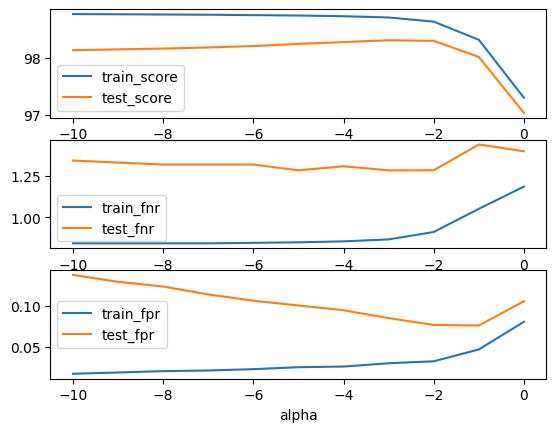

In [21]:
helpers.print_cv(cv_results_alpha, "alpha", logaxis=True)

In [22]:
ALPHA = 1e-2

Train model with chosen alpha

In [23]:
np.random.seed(1)
nb_model = MultinomialNB(alpha=ALPHA)
nb_model.fit(X_train, y_train)

# export model
joblib.dump(nb_model, "multinomialnb_model.joblib")

['multinomialnb_model.joblib']

Training metrics

In [24]:
nb_model = joblib.load("multinomialnb_model.joblib")

trainset = langdetect_dataset.loc[langdetect_dataset["split"]=="train", ]
trainset = helpers.nb_predict(nb_model, X_train, trainset, "text")

In [25]:
train_score_alpha = accuracy_score(trainset["language"], trainset["nb_predict"], normalize=True)*100
helpers.print_score(train_score_alpha, "Training")

Training accuracy: 98.62%


In [26]:
train_fnr_alpha = helpers.print_fnr(trainset["language"], trainset["nb_predict"], "Training")

Training FNR: 0.99%


In [27]:
train_fpr_alpha = helpers.print_fpr(trainset["language"], trainset["nb_predict"], "Training")

Training FPR: 0.04%


Compare metrics against model's prediction without threshold adjustment

In [28]:
train_score_base = accuracy_score(trainset["language"], trainset["best_predict"], normalize=True)*100
train_fnr_base = helpers.fnr(trainset["language"], trainset["best_predict"])
train_fpr_base = helpers.fpr(trainset["language"], trainset["best_predict"])

pd.DataFrame({"accuracy": [train_score_alpha, train_score_base],
              "fnr": [train_fnr_alpha, train_fnr_base],
              "fpr": [train_fpr_alpha, train_fpr_base]},
             index=["with adjustment (t=0.9)", "without adjustment"])

,accuracy,fnr,fpr
with adjustment (t=0.9),98.620219,0.989516,0.041736
without adjustment,99.464772,0.318059,0.067420


#### Probability Threshold level

Tune t, probability confidence level, in the threshold formula:  
threshold  
= t; if length < 10  
= exp(1/length)*t; else length >= 10  
where length = length of text

In [29]:
trainset = langdetect_dataset.loc[langdetect_dataset["split"]=="train", ]
cv_results_threshold = helpers.nb_tune_threshold(X_train, y_train, trainset, ALPHA, [0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9])

Fitting 5 folds for each of 11 candidates, totalling 55 fits
threshold = 0.8
[CV 5/5] END ..... total time:27.12s, train score=99.08, test score=98.76
threshold = 0.81
[CV 5/5] END ..... total time:26.88s, train score=99.06, test score=98.74
threshold = 0.82
[CV 5/5] END ..... total time:26.79s, train score=99.04, test score=98.71
threshold = 0.83
[CV 5/5] END ..... total time:25.48s, train score=99.01, test score=98.68
threshold = 0.84
[CV 5/5] END ..... total time:26.94s, train score=98.98, test score=98.66
threshold = 0.85
[CV 5/5] END ..... total time:27.00s, train score=98.95, test score=98.62
threshold = 0.86
[CV 5/5] END ..... total time:27.12s, train score=98.91, test score=98.59
threshold = 0.87
[CV 5/5] END ..... total time:27.22s, train score=98.87, test score=98.53
threshold = 0.88
[CV 5/5] END ..... total time:27.10s, train score=98.81, test score=98.48
threshold = 0.89
[CV 5/5] END ..... total time:25.29s, train score=98.75, test score=98.40
threshold = 0.9
[CV 5/5] END .

Cross-validation results

In [30]:
pd.DataFrame(cv_results_threshold)

,threshold,train_score,train_fnr,train_fpr,test_score,test_fnr,test_fpr
0,0.80,99.078878,0.603345,0.040124,98.759659,0.936881,0.087959
1,0.81,99.055739,0.615039,0.039321,98.739565,0.960528,0.087318
2,0.82,99.035645,0.641563,0.039321,98.713382,0.960528,0.087318
3,0.83,99.010832,0.653327,0.037716,98.683545,0.972813,0.086033
4,0.84,98.980083,0.688688,0.036914,98.655536,0.984106,0.083462
5,0.85,98.948724,0.724049,0.035309,98.619610,0.995734,0.082178
6,0.86,98.911429,0.747631,0.035309,98.587338,1.030379,0.079612
7,0.87,98.865456,0.782941,0.034506,98.534973,1.078987,0.078971
8,0.88,98.814460,0.815298,0.034506,98.475909,1.150164,0.078971
9,0.89,98.746415,0.847771,0.034506,98.402231,1.185800,0.077045


There is a trade-off between FNR and FPR.

*   For this project, FN is a most costly error than FP
*   The change in FPR is minimal for different values of t
*   FNR moves in the same direction as accuracy score

t = 0.86 is chosen for the threshold formula

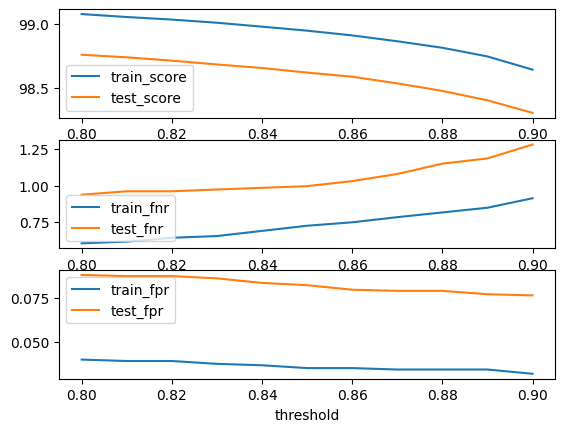

In [31]:
helpers.print_cv(cv_results_threshold, "threshold")

In [32]:
THRESHOLD = 0.8

Training metrics with new threshold formula

In [33]:
nb_model = joblib.load("multinomialnb_model.joblib")

In [34]:
trainset = langdetect_dataset.loc[langdetect_dataset["split"]=="train", ]
trainset = helpers.nb_predict(nb_model, X_train, trainset, "text", t=THRESHOLD)

train_score_t = accuracy_score(trainset["language"], trainset["nb_predict"], normalize=True)*100
helpers.print_score(train_score_t, "Training")

Training accuracy: 99.06%


In [35]:
train_fnr_t = helpers.print_fnr(trainset["language"], trainset["nb_predict"], "Training")

Training FNR: 0.65%


In [36]:
train_fpr_t = helpers.print_fpr(trainset["language"], trainset["nb_predict"], "Training")

Training FPR: 0.05%


Compare metrics against model's prediction, default threshold and chosen threshold

In [37]:
pd.DataFrame({"accuracy": [train_score_t, train_score_alpha, train_score_base],
              "fnr": [train_fnr_t, train_fnr_alpha, train_fnr_base],
              "fpr": [train_fpr_t, train_fpr_alpha, train_fpr_base]},
             index=["with adjustment(t=0.8)", "with adjustment(t=0.9)", "without adjustment"])

,accuracy,fnr,fpr
with adjustment(t=0.8),99.060458,0.647897,0.048157
with adjustment(t=0.9),98.620219,0.989516,0.041736
without adjustment,99.464772,0.318059,0.067420


Examine text with predicted language = UNKNOWN

In [38]:
trainset.loc[trainset["nb_predict"] == "UNKNOWN", "text"].str.len().mean()

16.874892148403795

In [39]:
trainset.loc[trainset["nb_predict"] == "UNKNOWN", ["threshold", "best_prob"]].mean()

threshold    0.838092
best_prob    0.633879
dtype: float64

### Unicode Rule

Adapted from guess-language by [@kent37](https://github.com/kent37/guess-language)

Train language specific n grams using train set

In [40]:
N_VALUE = 3
N_FEATURE = 300
TRAINSET = trainset.copy()

In [41]:
N_GRAMS = helpers.train_ngrams(TRAINSET, N_VALUE, N_FEATURE)

# export N-grams
with open("N_GRAMS.pickle", "wb") as handle:
  pickle.dump(N_GRAMS, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [42]:
with open("N_GRAMS.pickle", "rb") as handle:
  N_GRAMS = pickle.load(handle)

Showcase unicode rule to assign new language class for predicted language = UNKNOWN

In [43]:
# mapping
helpers.SCRIPT_TO_LANGUAGE

{'Malayalam': 'Malayalam',
 'Tamil': 'Tamil',
 'Thai': 'Thai',
 'Devanagari': 'Hindi',
 'Latin Extended Additional': 'Vietnamese',
 'Greek and Coptic': 'Greek',
 'Greek Extended': 'Greek',
 'Hiragana': 'Japanese',
 'Katakana': 'Japanese',
 'Katakana Phonetic Extensions': 'Japanese',
 'Hangul Syllables': 'Korean',
 'Hangul Jamo': 'Korean',
 'Hangul Compatibility Jamo': 'Korean',
 'Hangul Jamo Extended-A': 'Korean',
 'Hangul Jamo Extended-B': 'Korean',
 'CJK Radicals Supplement': 'Chinese',
 'CJK Symbols and Punctuation': 'Chinese',
 'CJK Strokes': 'Chinese',
 'CJK Compatibility': 'Chinese',
 'CJK Unified Ideographs Extension A': 'Chinese',
 'CJK Unified Ideographs': 'CJK',
 'CJK Compatibility Ideographs': 'Chinese',
 'CJK Compatibility Forms': 'Chinese',
 'Kangxi Radicals': 'Chinese',
 'Bopomofo': 'Chinese',
 'Bopomofo Extended': 'Chinese',
 'Latin-1 Supplement': 'EXTENDED LATIN',
 'Latin Extended-A': 'EXTENDED LATIN',
 'Latin Extended-B': 'EXTENDED LATIN',
 'Latin Extended-C': 'EXTENDE

In [44]:
# showcase step by step guide
unknown = TRAINSET.loc[TRAINSET["nb_predict"] == "UNKNOWN"].copy()
# count number of characters in each unicode block
unknown["blocks"] = unknown["text"].apply(lambda t: helpers.count_blocks(t))
# block with highest count (at least 30%)
unknown["highest"] = unknown["blocks"].apply(lambda b: helpers.highest_block(b))
# assign script to language
unknown["script"] = unknown["highest"].apply(lambda h: helpers.SCRIPT_TO_LANGUAGE[h] if h in helpers.SCRIPT_TO_LANGUAGE else "UNKNOWN")
# unicode rule can only apply to text with highest block >= 30% or script found in mapping
nonunknown = unknown.loc[unknown["script"]!="UNKNOWN"].copy()

In [45]:
nonunknown.iloc[[1,50,200,500,600],]

,raw,text,split,source,language,tokens,best_predict,best_prob,threshold,nb_predict,blocks,highest,script
347,Kennedy.,kennedy,train,basil,English,10990,English,0.238247,0.800000,UNKNOWN,{'Basic Latin': 1.0},Basic Latin,BASIC LATIN
6676,Pr.,pr,train,basil,Danish,3968,Polish,0.139308,0.800000,UNKNOWN,{'Basic Latin': 1.0},Basic Latin,BASIC LATIN
91208,Маловероятно .,маловероятно,train,papluca,Russian,22523 3667 313 1532 749,Russian,0.858921,0.869523,UNKNOWN,{'Cyrillic': 1.0},Cyrillic,CYRILLIC
146075,Es-tu le prophète ?,es tu le prophète,train,chazzer,French,74 429 41 6812 222 15398,French,0.839509,0.848470,UNKNOWN,"{'Basic Latin': 0.9285714285714286, 'Latin-1 S...",Basic Latin,BASIC LATIN
159834,Soltanto Tom sorrise.,soltanto tom sorrise,train,chazzer,Italian,2544 8242 72 23177 343,Italian,0.615504,0.841017,UNKNOWN,{'Basic Latin': 1.0},Basic Latin,BASIC LATIN


In [46]:
# step 1: main script = CJK, classify as Chinese, Korean, Japanese
def p1(row):
  if row["script"] == "CJK":
    return helpers.cjk_rule(row["blocks"])
  else:
    return row["script"]

nonunknown["p1"] = nonunknown.apply(lambda row: p1(row), axis=1)

In [47]:
# step 2: main script = ARABIC, CYRILLIC, LATIN, EXTENDED LATIN, classify based on unique char for each language
def p2(row):
  if row["p1"] in helpers.SCRIPT_TO_MULTILANGUAGE:
    new_lang = helpers.unique_chars(row["text"], row["p1"])
    if new_lang:
      return new_lang
  return row["p1"]

nonunknown["p2"] = nonunknown.apply(lambda row: p2(row), axis=1)

In [48]:
# step 3: main script = ARABIC, CYRILLIC, LATIN, EXTENDED LATIN
#         create a trigram
#         compare the distance of trigram against template of script with multilanguage
def p3(row):
  if row["p2"] in helpers.SCRIPT_TO_MULTILANGUAGE:
    if len(row["text"]) < 3:
      return "UNKNOWN"
    else:
      text_ngram = helpers.create_ngram([row["text"]], 3, 300, False)
      distances = {}
      languages = helpers.SCRIPT_TO_MULTILANGUAGE[row["p2"]]
      if row["p2"] == "BASIC LATIN" or row["p2"] == "EXTENDED LATIN":
        languages = helpers.SCRIPT_TO_MULTILANGUAGE["BASIC LATIN"] + helpers.SCRIPT_TO_MULTILANGUAGE["EXTENDED LATIN"]
      for language in languages:
        distance = helpers.ngram_distance(text_ngram, language, N_GRAMS, 300)
        distances[language] = distance
      return distances
  return row["p2"]

nonunknown["p3"] = nonunknown.apply(lambda row: p3(row), axis=1)

In [49]:
# step 4: main script = ARABIC, CYRILLIC, LATIN, EXTENDED LATIN
#         find language with minimum distance
def p4(d):
  if isinstance(d, dict):
    return (min(d, key=d.get), min(d.values()))
  else:
    return (d, False)

nonunknown["p4"] = nonunknown["p3"].apply(lambda d: p4(d))

In [50]:
# step 5: main script = ARABIC, CYRILLIC, LATIN, EXTENDED LATIN
#         compare the minimum distance vs distance to English language
def p5(row):
  if isinstance(row["p3"], dict):
    if "English" in row["p3"]:
      return (row["p3"]["English"] - row["p4"][1])/(row["p4"][1])
    else:
      return False
  else:
    return False

nonunknown["p5"] = nonunknown.apply(lambda row: p5(row), axis=1)

In [51]:
# step 6: if difference between minimum distance and distance to English is close
#         assign language as English (biased towards English to reduce FNR)
#         else, assign based on language with minimum distance
#         for tie, assign as UNKNOWN
def p6(row):
  if row["p5"] == False:
    return row["p4"][0]
  else:
    if row["p5"] < 0.01:
      return "English"
    else:
      return row["p4"][0]

nonunknown["p6"] = nonunknown.apply(lambda row: p6(row), axis=1)

In [52]:
# all steps are consolidated into unicode_predict()
nonunknown = helpers.unicode_predict(nonunknown, N_GRAMS, 3, 300, 0.01)

In [53]:
nonunknown.iloc[[1,50,200,500,600],]

,raw,text,split,source,language,tokens,best_predict,best_prob,threshold,nb_predict,blocks,highest,script,p1,p2,p3,p4,p5,p6,unicode_predict
347,Kennedy.,kennedy,train,basil,English,10990,English,0.238247,0.800000,UNKNOWN,{'Basic Latin': 1.0},Basic Latin,BASIC LATIN,BASIC LATIN,BASIC LATIN,"{'English': 90000, 'Latin': 90000, 'Indonesian...","(Danish, 89657)",0.003826,English,English
6676,Pr.,pr,train,basil,Danish,3968,Polish,0.139308,0.800000,UNKNOWN,{'Basic Latin': 1.0},Basic Latin,BASIC LATIN,BASIC LATIN,BASIC LATIN,UNKNOWN,"(UNKNOWN, False)",False,UNKNOWN,UNKNOWN
91208,Маловероятно .,маловероятно,train,papluca,Russian,22523 3667 313 1532 749,Russian,0.858921,0.869523,UNKNOWN,{'Cyrillic': 1.0},Cyrillic,CYRILLIC,CYRILLIC,CYRILLIC,"{'Russian': 89708, 'Bulgarian': 89741}","(Russian, 89708)",False,Russian,Russian
146075,Es-tu le prophète ?,es tu le prophète,train,chazzer,French,74 429 41 6812 222 15398,French,0.839509,0.848470,UNKNOWN,"{'Basic Latin': 0.9285714285714286, 'Latin-1 S...",Basic Latin,BASIC LATIN,BASIC LATIN,BASIC LATIN,"{'English': 88498, 'Latin': 89073, 'Indonesian...","(French, 88229)",0.003049,English,English
159834,Soltanto Tom sorrise.,soltanto tom sorrise,train,chazzer,Italian,2544 8242 72 23177 343,Italian,0.615504,0.841017,UNKNOWN,{'Basic Latin': 1.0},Basic Latin,BASIC LATIN,BASIC LATIN,BASIC LATIN,"{'English': 88745, 'Latin': 89015, 'Indonesian...","(Portuguese, 88427)",0.003596,English,English


#### Margin
Tune m, margin, in the unicode rule  
It represents the level of biasness towards classifying text as English

In [54]:
cv_results_margin = helpers.unicode_tune_margin(TRAINSET, [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01], N_GRAMS, N_VALUE, N_FEATURE)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
margin = 0.001
[CV 5/5] END ..... total time:26.08s, train score=99.30, test score=99.30
margin = 0.002
[CV 5/5] END ..... total time:26.21s, train score=99.29, test score=99.29
margin = 0.003
[CV 5/5] END ..... total time:26.01s, train score=99.28, test score=99.28
margin = 0.004
[CV 5/5] END ..... total time:23.95s, train score=99.27, test score=99.27
margin = 0.005
[CV 5/5] END ..... total time:25.93s, train score=99.26, test score=99.26
margin = 0.006
[CV 5/5] END ..... total time:25.86s, train score=99.25, test score=99.25
margin = 0.007
[CV 5/5] END ..... total time:26.04s, train score=99.24, test score=99.24
margin = 0.008
[CV 5/5] END ..... total time:25.02s, train score=99.23, test score=99.23
margin = 0.009
[CV 5/5] END ..... total time:25.52s, train score=99.22, test score=99.22
margin = 0.01
[CV 5/5] END ..... total time:26.02s, train score=99.21, test score=99.21


In [55]:
pd.DataFrame(cv_results_margin)

,margin,train_score,train_fnr,train_fpr,test_score,test_fnr,test_fpr
0,0.001,99.297323,0.412055,0.097099,99.297323,0.408596,0.102091
1,0.002,99.290625,0.412055,0.128395,99.290625,0.408596,0.133553
2,0.003,99.280273,0.388496,0.175741,99.280273,0.385018,0.177202
3,0.004,99.270531,0.329621,0.226297,99.270531,0.326536,0.227281
4,0.005,99.260788,0.258986,0.274445,99.260788,0.256616,0.274157
5,0.006,99.249219,0.235427,0.316976,99.249219,0.233038,0.318461
6,0.007,99.241303,0.235427,0.365927,99.241303,0.233038,0.365982
7,0.008,99.227298,0.235427,0.417285,99.227298,0.233038,0.417991
8,0.009,99.221818,0.223678,0.442964,99.221818,0.221745,0.445602
9,0.010,99.210249,0.211930,0.477471,99.210249,0.210452,0.480273


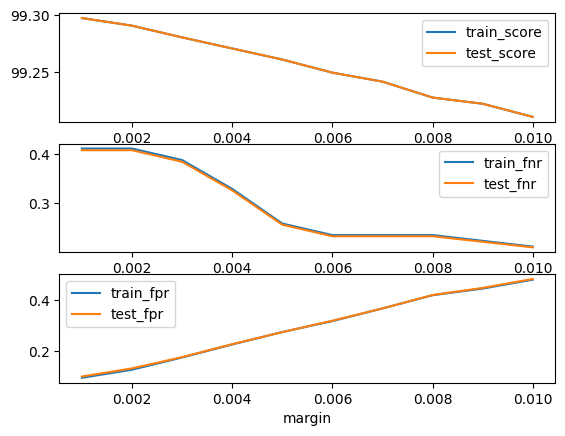

In [56]:
helpers.print_cv(cv_results_margin, "margin")

In [57]:
MARGIN = 0.006

Training metrics with unicode rule

In [58]:
trainset = helpers.unicode_predict(TRAINSET, N_GRAMS, N_VALUE, N_FEATURE, MARGIN)

In [59]:
train_score_unicode = accuracy_score(trainset["language"], trainset["unicode_predict"], normalize=True)*100
helpers.print_score(train_score_unicode, "[Unicode] Train")

[Unicode] Train accuracy: 99.25%


In [60]:
train_fnr_unicode = helpers.print_fnr(trainset["language"], trainset["unicode_predict"], "[Unicode] Train")

[Unicode] Train FNR: 0.24%


In [61]:
train_fpr_unicode = helpers.print_fpr(trainset["language"], trainset["unicode_predict"], "[Unicode] Train")

[Unicode] Train FPR: 0.32%


Compare training metrics with NB model performance

In [62]:
pd.DataFrame({"accuracy": [train_score_unicode, train_score_t, train_score_alpha, train_score_base],
              "fnr": [train_fnr_unicode, train_fnr_t, train_fnr_alpha, train_fnr_base],
              "fpr": [train_fpr_unicode, train_fpr_t, train_fpr_alpha, train_fpr_base]},
             index=["NB model(t=0.8)+Unicode Rule", "NB model(t=0.8)", "NB model(t=0.9)", "NB model"])

,accuracy,fnr,fpr
NB model(t=0.8)+Unicode Rule,99.249219,0.235599,0.318480
NB model(t=0.8),99.060458,0.647897,0.048157
NB model(t=0.9),98.620219,0.989516,0.041736
NB model,99.464772,0.318059,0.067420


Examine text with predicted language = UNKNOWN

In [63]:
trainset.loc[trainset["unicode_predict"] == "UNKNOWN", "best_prob"].mean()

0.5334796481618214

## Model evaluation

Test metrics of NB model with no threshold adjustment

In [64]:
testset = langdetect_dataset.loc[langdetect_dataset["split"]=="test", ]
testset = helpers.nb_predict(nb_model, X_test, testset, "text", t=THRESHOLD)

test_score_base = accuracy_score(testset["language"], testset["best_predict"], normalize=True)*100
test_fnr_base = helpers.fnr(testset["language"], testset["best_predict"])
test_fpr_base = helpers.fpr(testset["language"], testset["best_predict"])

Test metrics of NB model (with alpha = 0.01 and threshold = 0.8)

In [65]:
test_score_t = accuracy_score(testset["language"], testset["nb_predict"], normalize=True)*100
test_fnr_t = helpers.fnr(testset["language"], testset["nb_predict"])
test_fpr_t = helpers.fpr(testset["language"], testset["nb_predict"])

Test metrics of NB model + Unicode rule

In [66]:
testset = helpers.unicode_predict(testset, N_GRAMS, N_VALUE, N_FEATURE, MARGIN)

In [67]:
test_score_unicode = accuracy_score(testset["language"], testset["unicode_predict"], normalize=True)*100
test_fnr_unicode = helpers.fnr(testset["language"], testset["unicode_predict"])
test_fpr_unicode = helpers.fpr(testset["language"], testset["unicode_predict"])

Compare test metrics

In [68]:
pd.DataFrame({"accuracy": [test_score_unicode, test_score_t, test_score_base],
              "fnr": [test_fnr_unicode, test_fnr_t, test_fnr_base],
              "fpr": [test_fpr_unicode, test_fpr_t, test_fpr_base]},
             index=["NB model(t=0.8)+Unicode Rule", "NB model(t=0.8)", "NB model"])

,accuracy,fnr,fpr
NB model(t=0.8)+Unicode Rule,99.075906,0.370028,0.392017
NB model(t=0.8),98.810500,0.647549,0.068730
NB model,99.288230,0.462535,0.094186


## Final Model

Create a pipeline for language detector model

In [69]:
sample_data = pd.read_csv("Data/langdetect_unseen.csv")

In [70]:
sample_data = sample_data.sample(5000)

In [71]:
language_detector.language_detector(sample_data, "text")

,text,language,sampled,predicted_language
6098287,Wij zijn vrijgezellen.,Dutch,False,Dutch
1082099,"Ela é estrangeira, mas fala chinês excelenteme...",Portuguese,False,Portuguese
2631190,Lo stavo pensando anche io uscendo dallo stadio!,Italian,False,Italian
4826456,I think that Tom is distressed.,English,False,English
682068,"Not that he couldn't, but he's too lazy a man ...",English,False,English
...,...,...,...,...
239674,It is hard for me to keep early hours.,English,False,English
5725202,Algeria has already committed to participating...,English,False,English
2776928,Tom bunu binlerce defa yaptı.,Turkish,False,Turkish
999054,Mam ochotę na krótka drzemkę.,Polish,False,Polish


## PREVIOUS WORK

Metrics

In [ ]:
helpers.print_fnr(testset["language"], testset["best_predict"], "Test")

| --- | Before | After 10k | After 20k | After 30k | After 40k | After 50k |
| --- | :---: | :---: | :---: | :---: | :---: | :---: |
| Training Accuracy | 98.13 | 93.99 | 94.97 | 95.32 | 95.39 | 95.43 |
| Training FNR | 1.67 | 2.85 | 2.07 | 1.84 | 1.62 | 1.54 |
| Test Accuracy | 98.52 | 91.55 | 91.98 | 92.62 | 92.64 | 92.7 |
| Test FNR | 0.77 | 0.86 | 0.69 | 0.77 | 0.77 | 0.69 |
| Test Accuracy | 99.19 | 95.67 | 95.98 | 96.39 | 96.44 | 96.5 |
| Test FNR | 0.6 | 0.69 | 0.52 | 0.52 | 0.52 | 0.52 |



Unicode rule

In [ ]:
# unicode english / non english
testset['unicode'] = testset['text'].apply(lambda text: helpers.engCheck(text))

In [ ]:
# filter out best_prob less than threshold
check = testset[testset['best_prob'] < testset['threshold']]
# set those that has english unicode and best_prob < threshold to english
testset.loc[(testset['best_prob'] < testset['threshold'])& (testset['unicode'] == 'Eng Unicode'),'nb_predict'] = "English"